# Laborator 7: model de regresie logistică

## Descrierea temei

Descrierea problemei si a setului de date se gasesc in `data/fashion-mnist-readme.txt`. Setul de date este in fisierele `/data/fashion-mnist_train.csv` și `/data/fashion-mnist_train.csv`. Se va aplica model de regresie logistică pentru predicția etichetei clasei vestimentare din care face parte fiecare imagine (prima coloana din setul de date), folosind ca intrari valorile din celelalte coloane. 

Implementarea se va face folosind functii de NumPy. Se va folosi calcul vectorizat, pe cat posibil. 

Predarea temei se va face în săptămâna **20-24 noiembrie**, seara dinaintea laboratorului, **ora 20**, conform deadline-ului setat diferențiat pe grupe, pe platformă.
Cerinte si precizari:
1. Studentii se pot consulta intre ei, dar rezolvarile vor fi individuale. Necunoasterea codului prezentat inseamna nota 1 pentru tema curenta.

2. Se se faca adnotari de tipuri pentru variabilele folosite, parametrii de intrare ai functiilor si tipurile de retur. Neindeplinirea acestei cerinte duce la injumatatirea notei.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Regresia logistică - noțiuni teoretice 

**Regresia liniară** 'potriveşte' o funcţie liniară (polinomială) folosind un set de date $X$, pe tot domeniul $\mathbb{R}$, $linreg(x) : \mathbb{R}^m \rightarrow \mathbb{R}$. 

**Regresia logistică** are acelaşi domeniu, însă codomeniul este un set mult mai restrâns, şi anume $logreg(x) : \mathbb{R}^n \rightarrow (0, 1)$. 
Codomeniul $(0,1)$ se datorează faptului că regresia logistică încearcă să prezică probabilitatea ca elementul $x \in X$ să facă parte din clasa pozitivă.

Această probabilitate o notăm cu $P(y=1|x,\theta)$, şi o interpretăm ca fiind probabilitatea asociată răspunsului $x^T \theta$ calculat de regresia clasică, în condiţiile în care cunoaştem feature-urile $X$ şi parametrii $\theta$ ai modelului.

Ideea este că pentru fiecare intrare $x$, modelul regresiei logistice asociază o probabilitate. Vom arăta cum alegem funcţia care calculează probabilitatea folosind răspunsul regresiei liniare $x^T \theta$.

Pornim de la o funcţie care are ca parametru o probabilitate şi care mapează intervalul $(0,1)$ în toată axa reală $\mathbb{R}$. Observăm cum funcţia $f_1(p) = \frac{p}{1-p}$ mapează probabilitatea în $\mathbb{R}^+$, iar dacă aplicăm logaritmul, funcţia $f_2(p) = log\left(\frac{p}{1-p}\right)$ mapează intervalul $(0, 1)$ în toată axa reală $\mathbb{R}$.

Acest lucru reiese și din reprezentarea grafică a funcțiilor:

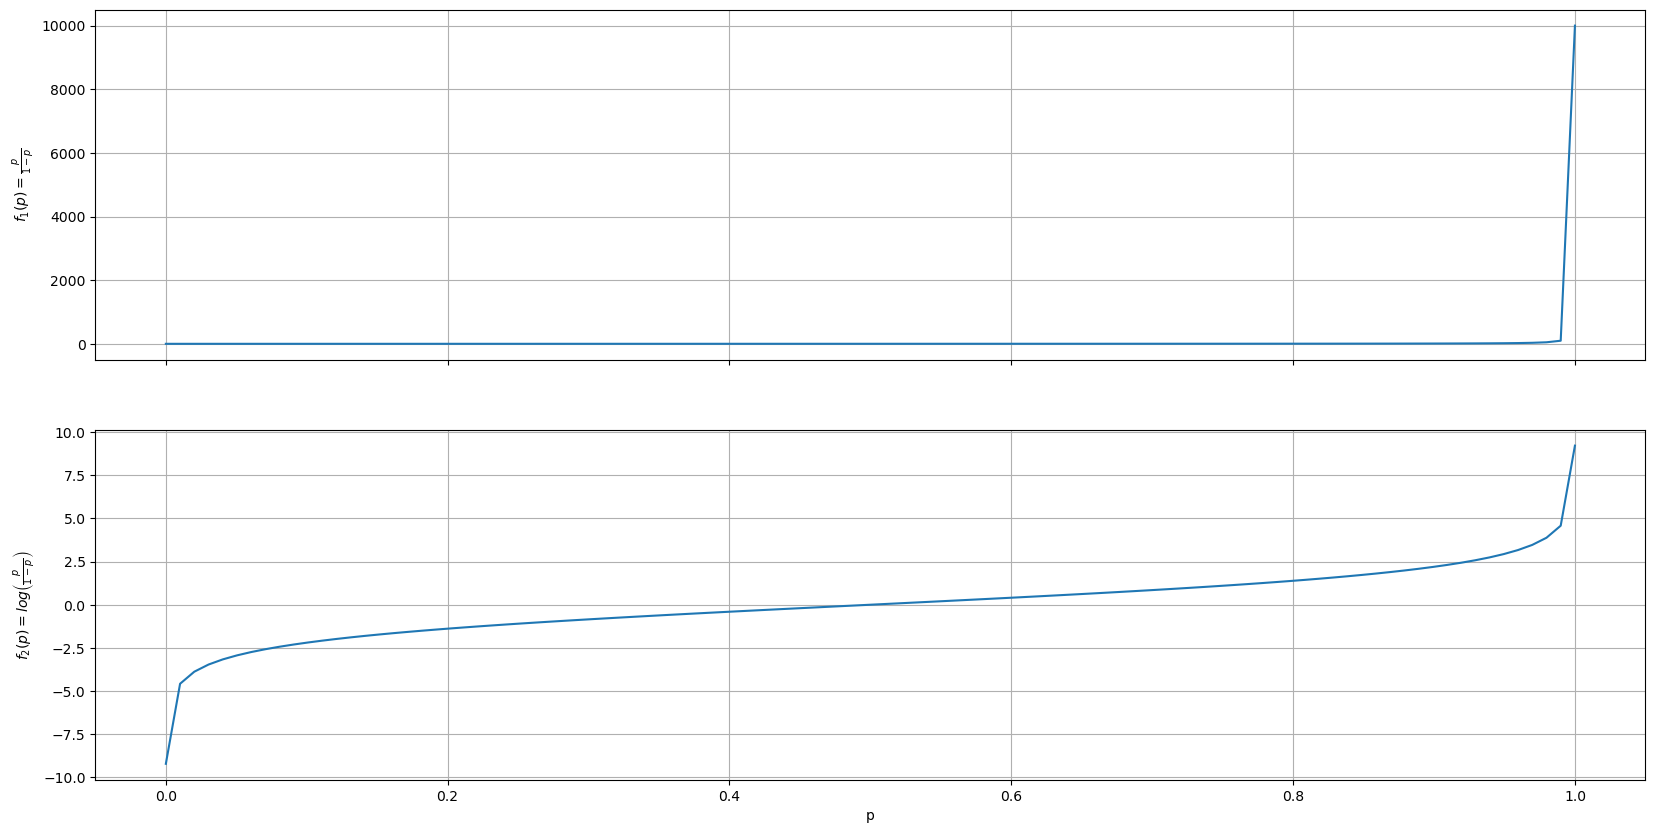

In [2]:
f1 = lambda x: x / (1 - x)
f2 = lambda x: np.log(x / (1 - x))
x = np.linspace(1e-4, 1-1e-4, 100)

fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(x, f1(x)) ; ax[1].plot(x, f2(x))
ax[0].set_ylabel(r'$f_1(p) = \frac{p}{1-p}$') ; ax[0].grid()
ax[1].set_xlabel('p') ; ax[1].set_ylabel(r'$f_2(p) = log\left(\frac{p}{1-p}\right)$') ; ax[1].grid()
plt.show()

## Importarea bibliotecilor, citirea datelor folosind Pandas dataframe

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Union

plt.rc('font', **{'size' : 18})

Setul de date ``fashion-mnist`` este direct împărțit în date pentru antrenare (fișierul ``fashion-mnist_train.csv``) și date pentru testare (fișierul ``fashion-mnist_test.csv``). Să citim și să încărcăm corespunzător datele din cele 2 fișiere:

In [4]:
path_train = './data/fashion-mnist_train.csv'
path_test = './data/fashion-mnist_test.csv'


train_data = pd.read_csv(path_train)
test_data=pd.read_csv(path_test)

assert(train_data.shape) == (60000, 785),f'Fisierul nu a fost citit corect: s-a citit un continut de forma {train_data.shape}'
assert(test_data.shape) == (10000, 785),f'Fisierul nu a fost citit corect: s-a citit un continut de forma {test_data.shape}'


#primele 5 linii din setul de antrenare
train_data.head(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Să separăm imagininile din setul de date de etichetele lor.
Matricele ``train_set`` si ``test_set`` contin pe prima coloana clasa (o cifra de la 0 la 9),
iar imaginea este păstrată începând de pe coloana 1 până la terminare.

Decupați în ``train_x`` doar imaginile iar în ``train_y`` doar clasa, și faceți același lucru și pentru ``test_x`` și ``test_y``.

In [5]:
# train_set si test_set sunt matrice care contin pe prima coloana clasa (o cifra de la 0 la 9),
#  iar imaginea este pastrata incepand de pe coloana 1 pana la terminare.
# Decupati in train_x doar imaginile iar in train_y doar clasa,
#  si faceti acelasi lucru si pentru test_x si test_y

train_x, train_y = train_data.iloc[:, 1:].values , train_data.iloc[:, 0].values
test_x, test_y = test_data.iloc[:, 1:].values , test_data.iloc[:, 0].values

assert train_x.shape == (60000, 784)
assert train_y.shape == (60000,)
assert test_x.shape == (10000, 784)
assert test_y.shape == (10000,)

Să vizualizăm setul de date. Vom reprezenta primele 16 linii din setul de antrenare:

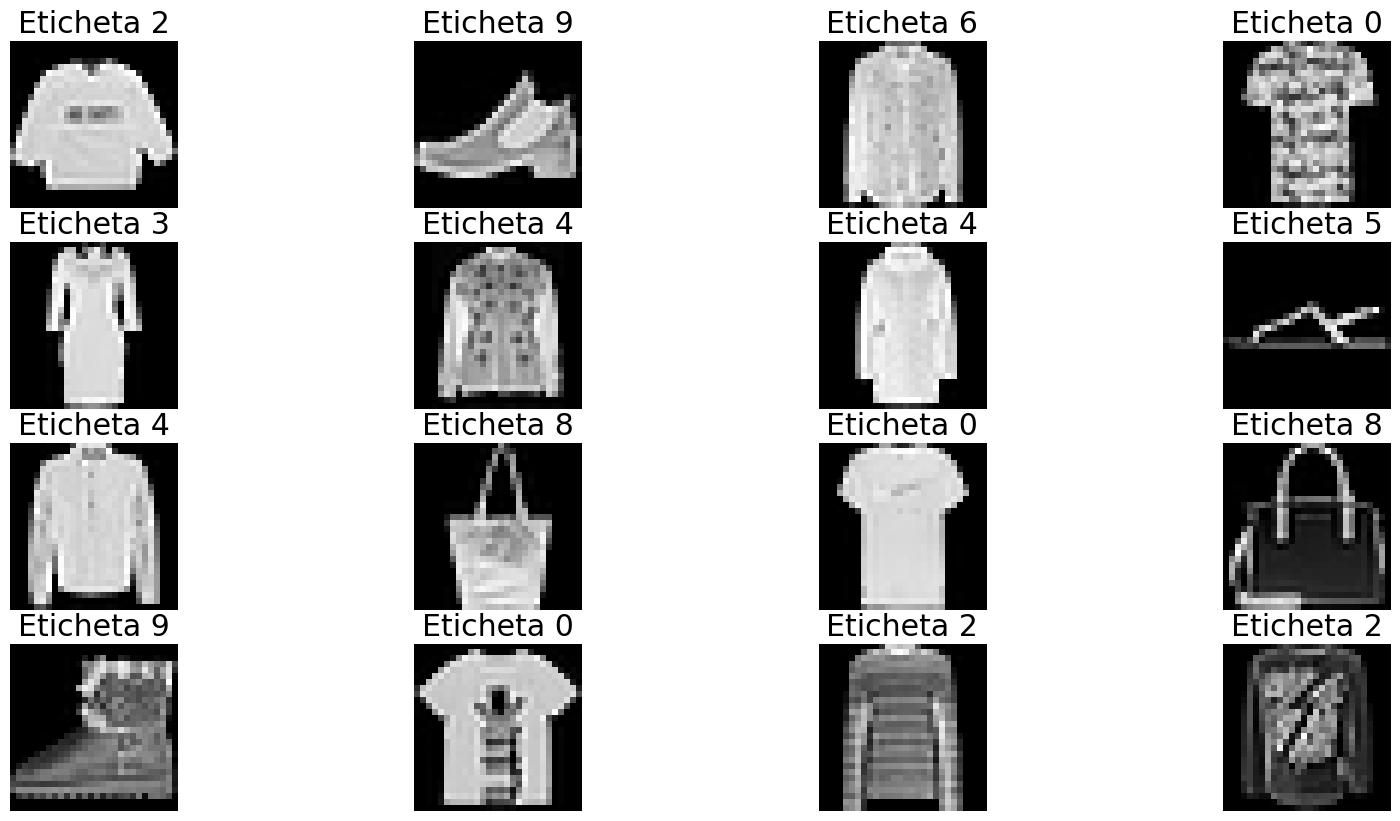

In [6]:
def show_samples(x_set:np.ndarray, y_set:np.ndarray):
    size:int = x_set.shape[0]
    
    fig, ax = plt.subplots(size // 4, 4, figsize=(20, 10))
    for k in range(size):
        row, col = k // 4, k % 4
        
        # Make those columns into a array of 8-bits pixels
        # The pixel intensity values are integers from 0 to 255
        pixels:np.ndarray = np.array(x_set[k], dtype='uint8')    
        
        # Reshape the array into 28 x 28 array (2-dimensional array)
        n:int = int(np.sqrt(len(pixels)))
        assert n**2 == len(pixels)
        pixels:np.ndarray = pixels.reshape(n, n)
        ax[row, col].imshow(pixels, cmap='gray')
        ax[row, col].set_title('Eticheta {label}'.format(label=y_set[k]))
        ax[row, col].axis('off')

    plt.show()
    
show_samples(train_x[:16, :], train_y[:16])

Să decodificăm etichetele imaginilor:


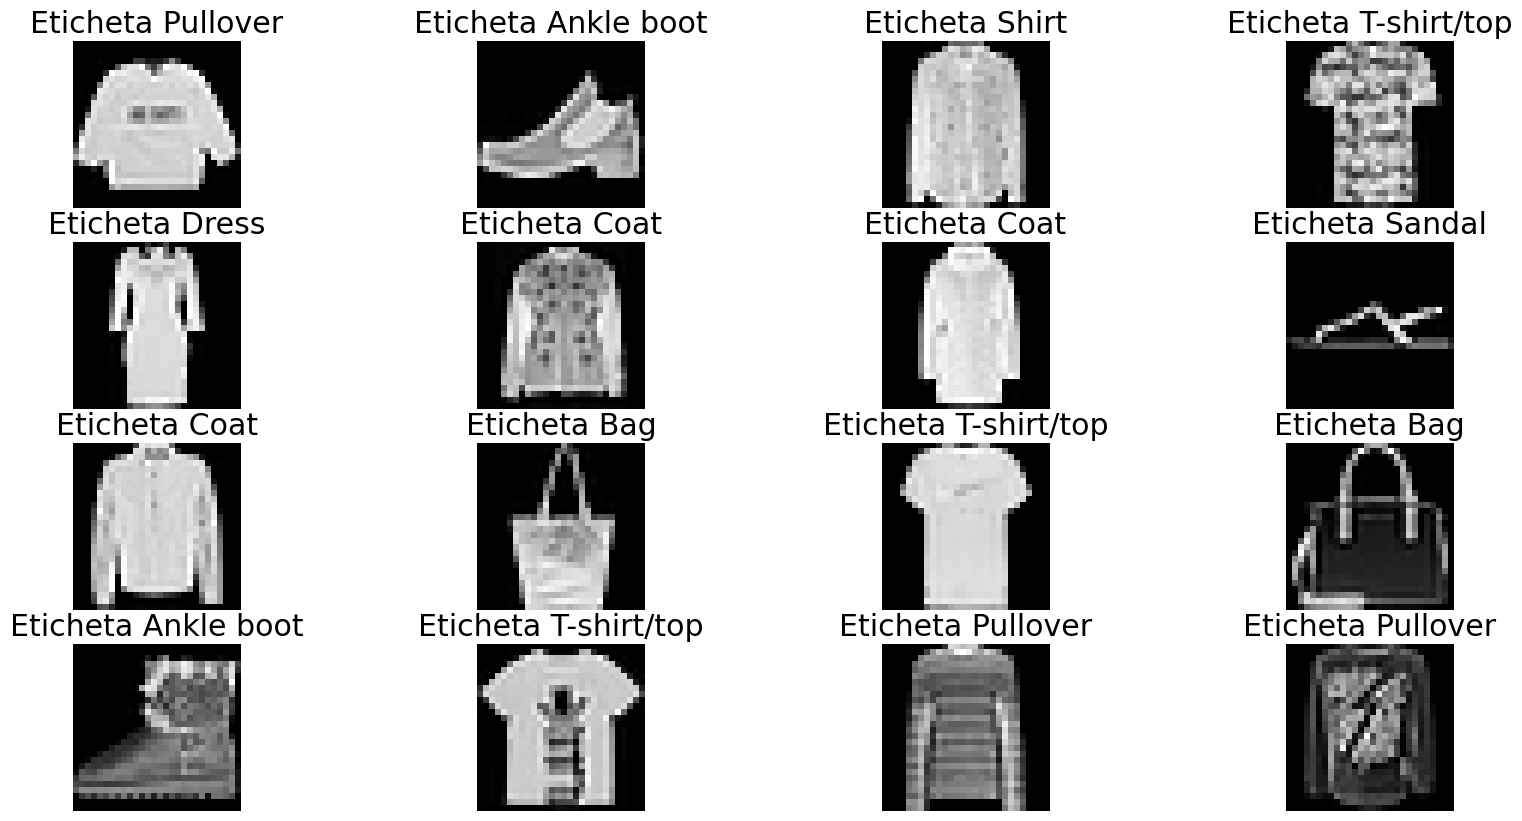

In [7]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# classes[y[i,0]]
def show_samples(x_set:np.ndarray, y_set:np.ndarray):
    size = x_set.shape[0]
    
    fig, ax = plt.subplots(size // 4, 4, figsize=(20, 10))
    for k in range(size):
        row, col = k // 4, k % 4
        
        # Make those columns into a array of 8-bits pixels
        # The pixel intensity values are integers from 0 to 255
        pixels = np.array(x_set[k], dtype='uint8')    
        
        # Reshape the array into 28 x 28 array (2-dimensional array)
        n = int(np.sqrt(len(pixels)))
        assert n**2 == len(pixels)
        pixels = pixels.reshape(n, n)
        ax[row, col].imshow(pixels, cmap='gray')
        ax[row, col].set_title('Eticheta {label}'.format(label=classes[y_set[k]]))
        ax[row, col].axis('off')

    plt.show()
    
show_samples(train_x[:16, :], train_y[:16])


## Funcții pentru procesarea datelor 


Pentru început, vom scrie algortimul de regresia BINOMIALĂ. Prin urmare, ne interesează să clasificăm deocamdată doar imaginile corespunzătoare a două clase, de exemplu pentru clasele '0' şi '1', adică ``T-shirt/top`` și ``Trouser``.
 Vom defini seturile care 'decupează' doar aceste două clase din seturile date:

In [8]:

# Filtrati din seturile mari doar acele sample-uri corespunzatoare claselor 0 si 1, adică ``T-shirt/top`` și ``Trouser``:
# determinati vectorii logici cu True pentru indicii pt care clasele din vectorii y sunt 0 sau 2 si False in rest

labels_0_1_train:np.ndarray = (train_y == 0) | (train_y == 1)
labels_0_1_test:np.ndarray = (test_y == 0) | (test_y == 1)


assert labels_0_1_train.shape == (60000,)
assert labels_0_1_test.shape == (10000,)

assert labels_0_1_train.sum() == 12000
assert labels_0_1_test.sum() == 2000

# # Filtrati din seturile mari doar acele sample-uri corespunzatoare claselor 0 si 1. 
# Puteti folosi reshape pentru vectorii y 
# Folositi vectorii logici labels_0_1_train si labels_0_1_test pentru filtrare

train_x_bin, train_y_bin = train_x[labels_0_1_train] , train_y[labels_0_1_train].reshape(-1,1)
test_x_bin, test_y_bin = test_x[labels_0_1_test] , test_y[labels_0_1_test].reshape(-1,1)

assert train_y_bin.shape == (12000, 1)
assert test_x_bin.shape == (2000, 784)
assert test_y_bin.shape == (2000, 1)

Functia de mai jos adauga o coloana de 1 la o matrice, pentru a putea reprezenta si ponderea pentru termenul liber (la fel cum am procedat în cazul regresiei liniare).

In [9]:
def augment_matrix(x: np.ndarray) -> np.ndarray:
    """
    Returns a matrix with first column filled with 1 and the other columns being x's columns.
    """
    ones_column:np.ndarray = np.ones((x.shape[0], 1))
    result:np.ndarray = np.hstack((ones_column, x))
    return result

train_x_bin_ext:np.ndarray = augment_matrix(train_x_bin)
test_x_bin_ext:np.ndarray = augment_matrix(test_x_bin)

assert train_x_bin_ext.shape == (12000, 785)
assert test_x_bin_ext.shape == (2000, 785)
assert np.all(train_x_bin_ext[:, 0] == 1)
assert np.all(test_x_bin_ext[:, 0] == 1)

Funcția următoare trebuie să preia o matrice si să faca scalarea la intervalul [0, 1] a fiecărei coloane (trăsături/feature) (similar scalării cu valorile de minim și maxim din regresia liniră).
Fiind valori de pixeli, valoarea maximă este 255. Prin urmare, normalizarea va presupune doar împărțirea Feature-urilor la valoarea maximă, 255.

In [10]:

def normalize(x: np.ndarray) -> np.ndarray:
    """
    Normalization means division by 255.
    
    Args:
        x: feature matrix, shape m * n. It will not be changed by this code.
    
    Returns:
        matrix with scaled values between 0 and 1, of same shape
    """
    min_val = np.min(x)
    max_val = np.max(x)
    range = max_val - min_val
    return (x - min_val) / range


## testarea funcției
train_x_bin_ext = augment_matrix(normalize(train_x_bin))
test_x_bin_ext = augment_matrix(normalize(test_x_bin))

assert train_x_bin_ext.shape == (12000, 785)
assert test_x_bin_ext.shape == (2000, 785)
assert np.all(train_x_bin_ext[:, 0] == 1)
assert np.all(test_x_bin_ext[:, 0] == 1)
assert np.all(train_x_bin_ext <= 1)
assert np.all(test_x_bin_ext <= 1)
assert np.all(train_x_bin_ext >= 0)
assert np.all(test_x_bin_ext >= 0)

## Functii pentru antrenare

Vom calcula funcția sigmoidă:

$$
sigmoid(z) = \frac{1}{1 + e^{-z}}$$
respectiv 
$$
\hat y = h(x, \theta) = sigmoid \left( X  \theta \right)
$$


In [11]:

def sigmoid(z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    return 1 / (1 + np.exp(-z))


assert sigmoid(0) == 0.5
assert np.abs(sigmoid(1) - 0.731058) < 1e-6

def h(x: Union[float, np.ndarray], theta: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    return sigmoid(x @ theta)

assert np.abs(h(np.array([1., 1., 1., 0]), np.array([1., 0., 1., 1.])) - 0.880797) < 1e-6

Calculăm funcţia de cost cu regularizare de data aceasta (atenţie, coeficientul $\theta_0$ nu se regularizează):

\begin{align}
J(\boldsymbol\theta) & = \underbrace{-\frac{1}{m} \sum\limits_{i=1}^m \left[y^{(i)}\cdot \ln h_{\boldsymbol\theta}(\mathbf{x}^{(i)}) + (1-y^{(i)})\cdot \ln (1- h_{\boldsymbol\theta}(\mathbf{x}^{(i)})) \right]}_{\text{Eroarea de calitate}} 
\\
& + \underbrace{\frac{\lambda}{2} \sum\limits_{j=1}^n \theta_j^2}_{\text{termenul de regularizare}}
\\
& = 
\underbrace{-\frac{1}{m} \sum\limits_{i=1}^m \left[y^{(i)}\cdot \ln \hat y^{(i)}  + (1-y^{(i)})\cdot \ln (1- \hat y^{(i)}) \right]}_{\text{Eroarea de calitate}} 
\\
& + \underbrace{\frac{\lambda}{2} \sum\limits_{j=1}^n \theta_j^2}_{\text{termenul de regularizare}}
\\
& = -\frac{1}{m} \left(\mathbf{y}^t \cdot \ln\hat{\mathbf{y}}  + (\mathbb{1}-\mathbf{y})^t \cdot \ln(\mathbb{1}-\hat{\mathbf{y}})\right) + \| \boldsymbol\theta[1:]  \|^2_2
\end{align}

unde $\boldsymbol\theta[1:]$ este vectorul format din toate componentele lui $\boldsymbol\theta$ mai puțin prima, iar $\| \mathbf{v} \|_2$ este norma Euclidiană a vectorului $\mathbf{v}$.

In [12]:
def cost(x:np.ndarray, y:np.ndarray, theta:np.ndarray, lmbda:float)->float:
    """
    Cost function includes also regularization
    
    Args:
        x: matricea feature-urilor, dimensiune m x (n+1)
        y: vectorul evidentei, dimensiune m x 1
        theta: vectorul coeficientilor, dimensiune (n+1) x 1
        
    Returns:
        costul, ca scalar
    """
    assert x.shape[1] == theta.shape[0]
    assert x.shape[0] == y.shape[0]
    assert theta.shape[1] == y.shape[1] == 1
    assert lmbda >= 0
    # calculam y hat:
    y_hat = h(x, theta)
    
    # calculam eroarea de calitate
    m:int = x.shape[0]
    j1:float = sum(y*np.log(y_hat)+(1-y)*np.log(1-y_hat))/(-m)
    
    # calculam eroarea de regularizare
    j2:float = (lmbda/2) * np.sum(theta[1:] ** 2)

    return (j1 + j2).flatten()
    
np.random.seed(11)
n = train_x_bin_ext.shape[1]
theta = np.random.randn(n).reshape(n, 1)
assert np.abs(cost(train_x_bin_ext, train_y_bin, theta=theta, lmbda=0.2) -  79.74253882) < 1e-6,f'am primit {cost(train_x_bin_ext, train_y_bin, theta=theta, lmbda=0.2)}'

Calculăm gradientul, folosind expresia determinată anterior, şi ţinând seama de termenul de regularizare:

$$
\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta}) = \frac{1}{m} \mathbf{X}^t(\hat{\mathbf{y}} - \mathbf{y}) + \lambda (0, \theta_1, \dots, \theta_n)
$$

In [13]:

def grad(x:np.ndarray, y:np.ndarray, theta:np.ndarray, lmbda:float)->np.ndarray:
    """
    Computation of gradient with regularization term
    
    Args:
        x: matricea feature-urilor, dimensiune m x (n + 1)
        y: vectorul evidentei, dimensiune m
        theta: vectorul coeficientilor, dimensiune n+1
        lmbda: coeficientul de regularizare
        
    Returns:
        gradientul, vector de n+1 elemente
    """
   
    m:int = x.shape[0]
    y_hat:np.ndarray = h(x, theta)
    g1:np.ndarray = (1 / m) * (x.T @ (y_hat - y)) # gradientul de calitate, fara regularizare
    
    theta_simple:np.ndarray = theta.copy()
    theta_simple[0] = 0
    g2:np.ndarray = (lmbda / 2) * theta_simple # gradientul aferent termenului de regularizare
    
    g:np.ndarray = g1 + g2
    assert g.shape == theta.shape
    return g

np.random.seed(11)
n = train_x_bin_ext.shape[1]
theta = np.random.randn(n).reshape(n, 1)
res = grad(train_x_bin_ext, train_y_bin, theta=theta, lmbda=0.2)
assert res.shape == (785, 1)

Algoritmul de antrenare va stoca costul asociat fiecărei epoci într-o listă:

In [14]:
def compute_accuracy(x_set:np.ndarray, y_set:np.ndarray, theta:np.ndarray)->float:
    pred = ((h(x_set, theta) >= 0.5) * 1 == y_set)
    return 100.0 * sum(pred) / pred.shape[0]

In [15]:
# Set learning rate
eta:float = 0.2

# Set regularization coefficient
lmbda:float = 0.5

# In x, we have m instances of n features each
# Create theta as a vector (n x 1)
n = np.shape(train_x_bin_ext)[1]
theta:np.ndarray = np.random.randn(n).reshape(n, 1)

# Do the training
epochs:int = 40
values:list = []
accurracies:list = []
for i in range(epochs):
    theta -= eta * grad(train_x_bin_ext, train_y_bin, theta, lmbda)
    acc = compute_accuracy(train_x_bin_ext, train_y_bin, theta)
    values.append(cost(train_x_bin_ext, train_y_bin, theta, lmbda))
    accurracies.append(acc)
    
print("last cost: %g" % values[-1])

last cost: 3.51536


Reprezentarea grafică a funcției de cost și a acurateței:

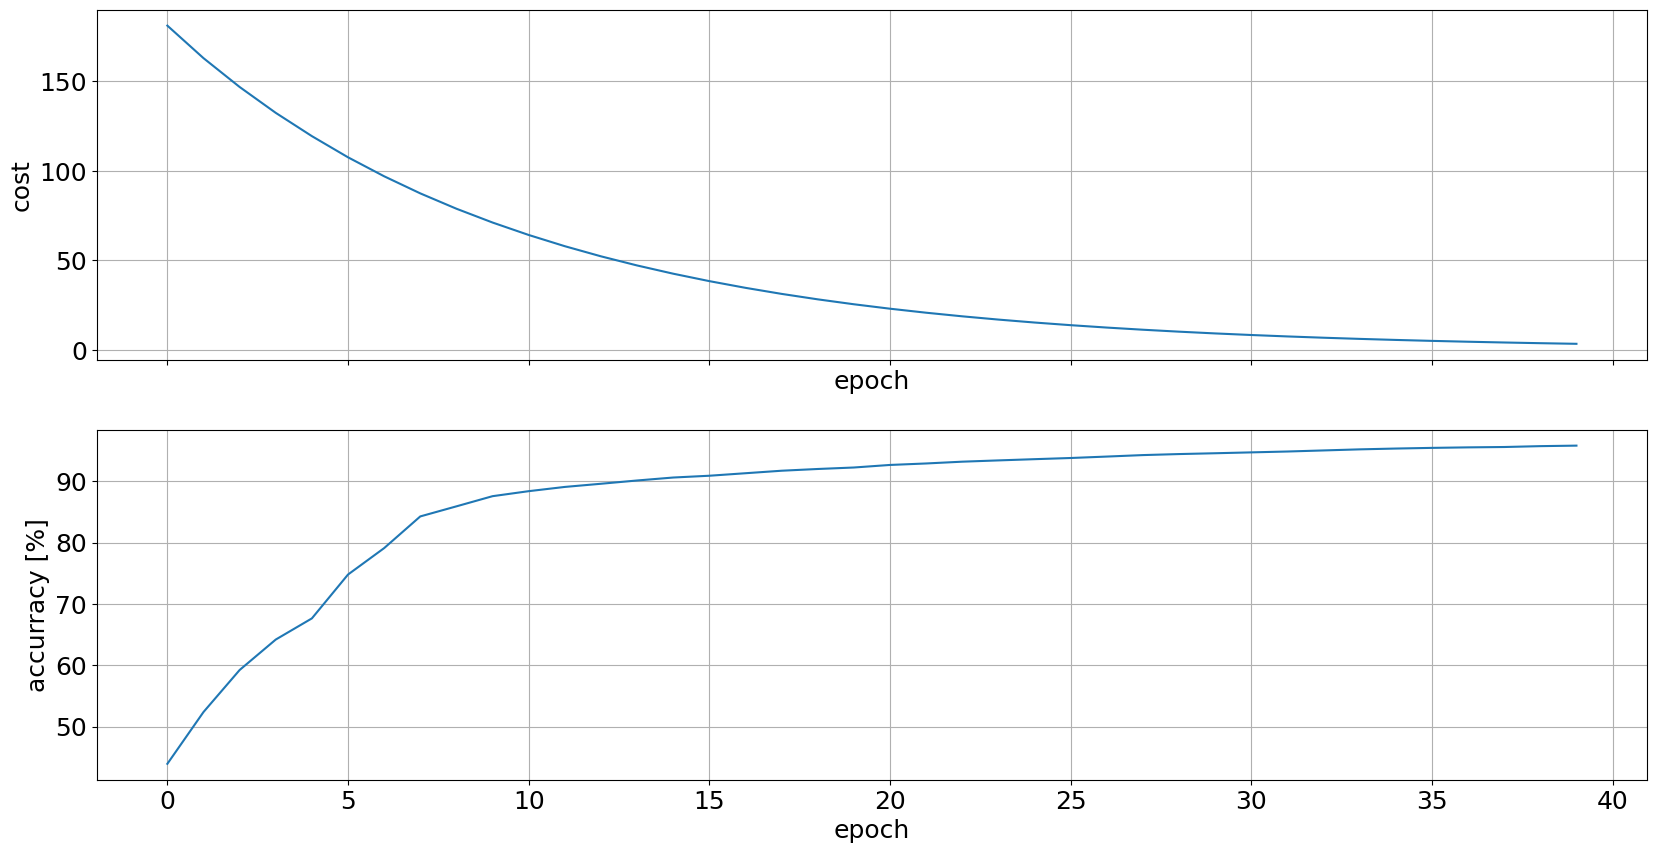

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(range(len(values)), values)
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot(range(len(accurracies)), accurracies)
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

## Matricea de confuzie

În continuare, vom reprezenta matricea de confuzie, un instrument care ne ajută să vizualizăm performanțele algortimului nostru.
Astfel, putem identifica rezultatele fals-pozitive și/sau fals-negative. 
Matricea de confuzie va afișa la intersectia linie/coloana cate sample-uri din clasa data de numarul liniei au fost prezise ca fiind facand parte din clasa data de numarul coloanei.

In [17]:
# pentru scrierea tabelelor:
!pip install tableprint 
import tableprint as tab

In [18]:

# Calculam acuratetea pentru setul de test
# Aceasta presupune sa numaram cate predictii se potrivesc cu realitatea si sa exprimam acest lucru procentual
pred:bool = ((h(test_x_bin_ext, theta) >= 0.5) * 1 == test_y_bin)
print("accuracy: %2.2f%% for %d patterns" % (compute_accuracy(test_x_bin_ext, test_y_bin, theta) , test_x_bin_ext.shape[0]))

# Calculam confusion matrix
# true positive: y = 1 and pred = 1
# true negative: y = 0 and pred = 0
# false positive: y = 0 and pred = 1
# false negative: y = 1 and pred = 0
pred:np.ndarray = (h(test_x_bin_ext, theta) >= 0.5) * 1
tp:int = np.sum((test_y_bin == 1) & (pred == 1))
tn:int = np.sum((test_y_bin == 0) & (pred == 0))
fp:int = np.sum((test_y_bin == 0) & (pred == 1))
fn:int = np.sum((test_y_bin == 1) & (pred == 0))

headers:list = ['Confusion Matrix', 'pred: 0', 'pred: 1', 'pred: all'] 
table:list = [
    ['actual: 0', tn, fp, tn + fp],
    ['actual: 1', fn, tp, fn + tp],
    ['actual: all', tn + fn, fp + tp, tn + fn + fp + tp]]
tab.table(table, headers, width=16)

accuracy: 95.35% for 2000 patterns
╭──────────────────┬──────────────────┬──────────────────┬──────────────────╮
│ Confusion Matrix │          pred: 0 │          pred: 1 │        pred: all │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│        actual: 0 │              963 │               37 │             1000 │
│        actual: 1 │               56 │              944 │             1000 │
│      actual: all │             1019 │              981 │             2000 │
╰──────────────────┴──────────────────┴──────────────────┴──────────────────╯


## Regresia Multinomială

În continuare vom implementa modelul de regresie multinomială. Vom antrena modelul pentru a clasifica toate imaginile din setul de date, folosind toate cele 10 clase.

Pentru început, pentru întreg setul de antrenare:
* vom normaliza matricea de Feature-uri
* vom adăuga coloana de 1-uri, corespunzătoare termenului liber.

In [19]:
# classes
k:int = 10

# Adaugam la features coloana de 1-uri
train_x_all_ext:np.ndarray = augment_matrix(normalize(train_x))
test_x_all_ext:np.ndarray = augment_matrix(normalize(test_x))

assert train_x_all_ext.shape == (60000, 785)
assert test_x_all_ext.shape == (10000, 785)
assert np.all(train_x_all_ext[:, 0] == 1)
assert np.all(test_x_all_ext[:, 0] == 1)
assert np.all(train_x_all_ext <= 1)
assert np.all(test_x_all_ext <= 1)
assert np.all(train_x_all_ext >= 0)
assert np.all(test_x_all_ext >= 0)

În continuare, vom realiza codificarea 'one-hot encoding', prin care vom converti un număr intreg la un array binar,
care are 1 doar pe o anumită poziție specificată.
Concret, în cazul nostru, fiecare clasă va fi codificată într-un vector k-dimensional (k=10=numărul claselor), format din zero-uri și valoarea 1 pe poziția aferentă clasei.

De exemplu:
 * 4 devine `[0 0 0 0 1 0 0 0 0 0]`
 * 0 devine `[1 0 0 0 0 0 0 0 0 0]`

In [20]:

def one_hot(val: int, classes: int) -> np.ndarray:
    """
    Realizeaza 'one-hot encoding', conversia unui intreg la un array binar,
    care are 1 doar pe pozitia specificata de val
    
    Args:
        val: clasa ce trebuie encodata, un intreg intre {0, 1, ... K-1}
        classes: numarul de clase K
        
    Returns:
        un array de zerouri de forma (1, classes), unde doar pe pozitia val avem o valoare 1
    """
    assert 0 <= val < classes
    result:np.ndarray = np.zeros((1, classes))
    result[0, val] = 1
    assert result.shape == (1, classes)
    return result

assert np.all(one_hot(7, k) == np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]))
assert np.all(one_hot(3, k) == np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]))

train_y_all:np.ndarray = np.concatenate([one_hot(int(i), k) for i in train_y])
test_y_all:np.ndarray = np.concatenate([one_hot(int(i), k) for i in test_y])
assert train_y_all.shape == (60000, 10)
assert test_y_all.shape == (10000, 10)
assert np.all((train_y_all != 0) == (train_y_all == 1))

Când calculăm produsul între matricea $X$, de dimensiune $(m, n)$, şi $\theta$, de dimensiune $(n, k)$,obținem rezultatul $X \theta$, de dimensiune $(m, k)$, unde:
* m = numărul de samples (imagini)
* n  =numărul de feature-uri
* k= numărul de clase

Funcţia $softmax()$ va avea aceleaşi dimensiuni $(m, k)$ şi trebuie să dea pe fiecare coloană suma $1$. Se poate scrie compact calculul ei astfel:

$$softmax(X, \theta) = \frac{e^{X \theta}}{e^{X \theta} \cdot \mathbb{1}_k}$$

Termenul de la numitor, $e^{X \theta} \cdot \mathbb{1}_k$, nu mai este o matrice, ci un vector de dimensiunea $(m, 1)$ (practic se realizează suma pe fiecare linie). Pentru realizarea împărţirii se realizează operaţia de broadcast.

In [21]:
# Vom verifica dimensiunile rezultate din  X@ Theta
m, n = train_x_all_ext.shape
np.random.seed(11)
theta:np.ndarray = np.random.randn(n, k)
assert (train_x_all_ext @ theta).shape == (m, k)

In [22]:

def softmax(x: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """"
    Calculul functie softmax
    
    Args:
        x: feature-urile, dimensiune m x n
        theta: parametrii, de dimensiune n x k
        
    Returns:
        produsul lor de dimensiune m x k
    """
    assert x.shape[1] == theta.shape[0]
    
    x_normalized = normalize(x)

    # Calculul exponentialelor
    exponentials:np.ndarray = np.exp(np.dot(x_normalized, theta))
    
    # Suma pe fiecare linie
    row_sum:np.ndarray = exponentials.sum(axis=1, keepdims=True)
    
    # Calculul softmax
    softmax_values:np.ndarray = exponentials / row_sum

    return softmax_values

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
smax = softmax(train_x_all_ext, theta)
assert smax.shape == (m, k)
assert np.all((smax.sum(axis=1) - 1) < 1e-12)

Funcţia de cost ce include regularizarea poate fi scrisă mai compact astfel (a se remarca indicele de sumare $i$ plecand de la 1):

$$J(\theta, \lambda) = -\frac{1}{m} \mathbb{1}_m^T \left\{ Y \odot \log[softmax(X \theta)] \mathbb{1}_k \right\} + \frac{\lambda}{2} \sum_{i=1}^{n-1}\sum_{j=0}^{k-1} \theta_{i,j}^2 = -\frac{1}{m} \mathbb{1}_m^T \left\{ Y \odot \log[softmax(X \theta)] \mathbb{1}_k \right\} + \frac{\lambda}{2} \|\Theta[1:, :]\|_F^2$$

unde pentru o matrice $A$ de tip $m\times n$, $\| A \|_F$ e norma Forbenius: $$\| A \|_F = \sqrt{\sum\limits_{i=0}^{m-1}\sum\limits_{j=0}^{n-1} |a_{ij}|^2}$$

In [23]:

def cost(x:np.ndarray, y:np.ndarray, theta:np.ndarray, lmbda:float)->float:
    """
    Costul include regularizarea
    
    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        costul, ca scalar

    """
    m, n = x.shape
    
    # Calculul functiei softmax
    smax:np.ndarray = softmax(x, theta)
    
    # Calculul costului fara regularizare
    j1:float = -np.sum(y * np.log(smax)) / m
    
    # Calculul termenului de regularizare
    reg_term:float = (lmbda / (2 * m)) * np.sum(theta[1:]**2)
    
    # Costul total
    cost_value:float = j1 + reg_term
    
    return cost_value

m, n = train_x_all_ext.shape
np.random.seed(11)
theta:np.ndarray = np.random.randn(n, k)
assert (cost(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2) - 815.14447672) < 1e-6

Gradientul se calculează astfel:

$$\nabla_{\theta}J = - \frac{1}{m} X^T \left[Y - softmax(X \theta) \right] + \lambda \left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$$

unde matricea $\left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$ are tot dimensiunea (n, k), ca şi $\theta$, doar că prima linie este zero.

In [24]:

def deltas(x:np.ndarray, y:np.ndarray, theta:np.ndarray, lmbda:float)->np.ndarray:
    """
    Calculeaza gradientul

    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        matricea gradientilor, de dimensiunea lui theta (n x k)
    """
    m, n = x.shape
    
    # Calculul functiei softmax
    smax:np.ndarray = softmax(x, theta)
    
    # Calculul gradientilor fara regularizare
    grad:np.ndarray = np.dot(x.T, (smax - y)) / m
    
    # Adaugarea termenului de regularizare (exceptand primul termen)
    grad[1:] += (lmbda / m) * theta[1:] #grad -> np.ndarray
    
    return grad

m, n = train_x_all_ext.shape
np.random.seed(11)
theta:np.ndarray = np.random.randn(n, k)
grad:np.ndarray = deltas(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2)

assert grad.shape == (n, k)

Să calculăm acuratețea modelului:

In [25]:
def calculate_accurracy(set_x:np.ndarray, set_y:np.ndarray, theta:np.ndarray)->float:
    """
    Calculeaza acuratetea pentru un set dat.

    Args:
        set_x: matricea de caracteristici, forma (m, n)
        set_y: etichetele reale, forma (m, k)
        theta: matricea de parametri, forma (n, k)
        
    Returns:
        Acuratetea in procente.
    """
    # Calculate the predicted probabilities using softmax
    predicted_probs:np.ndarray = softmax(set_x, theta)
    
    # Extract the predicted class labels
    predicted_labels:np.ndarray = np.argmax(predicted_probs, axis=1)
    
    # Extract the true class labels
    true_labels:np.ndarray = np.argmax(set_y, axis=1)
    
    # Calculate the accuracy
    correct_predictions:int = np.sum(predicted_labels == true_labels)
    total_samples:int = set_x.shape[0]
    accuracy:float = 100.0 * correct_predictions / total_samples
    
    return accuracy

Să antrenăm modelul de regresie multinomială.


In [26]:
# numarul de clase
k = 10

lmbda, alpha = 0.05, 1.1
m, n = train_x_all_ext.shape
np.random.seed(11)
theta:np.ndarray = np.random.randn(n, k)

epochs:int = 300
values:list = []
accurracies:list = []
for i in range(epochs):
    theta -= alpha * deltas(train_x_all_ext, train_y_all, theta, lmbda) #np.ndarray
    if (i % 10 == 0):
        values.append(cost(train_x_all_ext, train_y_all, theta, lmbda))
        accurracies.append(calculate_accurracy(test_x_all_ext, test_y_all, theta))
        print("epoch: ", i, "cost: ", values[-1], "accuracy: ", accurracies[-1])
        lmbda *= 0.9 #float
    
print("last costs: %g" % values[-1])

epoch:  0 cost:  17.910031865423107 accuracy:  9.46
epoch:  10 cost:  7.081813912989383 accuracy:  45.87
epoch:  20 cost:  4.911999979323951 accuracy:  52.55
epoch:  30 cost:  3.7684164612555873 accuracy:  60.5
epoch:  40 cost:  4.631827555323749 accuracy:  58.47
epoch:  50 cost:  1.856610377857725 accuracy:  67.79
epoch:  60 cost:  2.822144244956911 accuracy:  64.01
epoch:  70 cost:  3.206227237810873 accuracy:  66.68
epoch:  80 cost:  3.4421519399982277 accuracy:  66.26
epoch:  90 cost:  2.6889794063706183 accuracy:  66.81
epoch:  100 cost:  4.109988063307106 accuracy:  70.9
epoch:  110 cost:  2.589689385566122 accuracy:  64.94
epoch:  120 cost:  3.072557881557183 accuracy:  72.56
epoch:  130 cost:  3.822581041912918 accuracy:  64.67
epoch:  140 cost:  2.0133749858932926 accuracy:  72.77
epoch:  150 cost:  3.6554945985696166 accuracy:  72.6
epoch:  160 cost:  1.6511316188722174 accuracy:  74.32
epoch:  170 cost:  1.8490652971826873 accuracy:  72.84
epoch:  180 cost:  2.21111638850938

Vom reprezenta grafic acuratețea și funcția de cost pentru modelul  nostru:

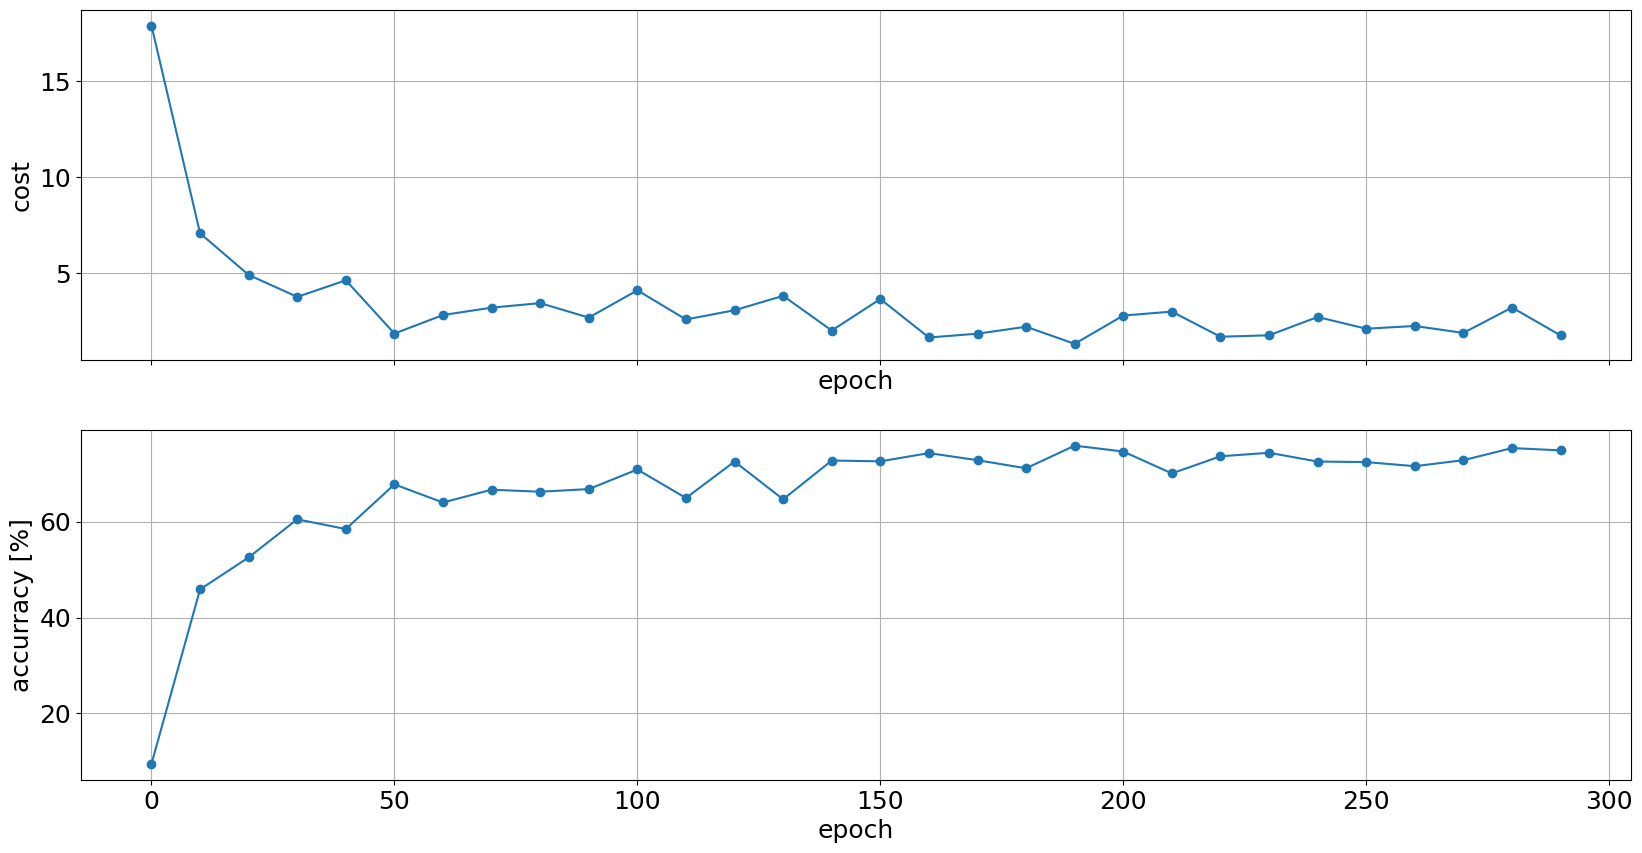

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot([x * 10 for x in range(len(values))], values, 'o-')
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot([x * 10 for x in range(len(accurracies))], accurracies, 'o-')
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

## Testarea modelului de regresie multinomială

Să calculăm acuratețea pentru setul de test. Aceasta presupune să numărăm câte predicții se potrivesc cu realitatea și să exprimăm acest lucru procentual:

In [28]:
# Calculam acuratetea pentru setul de test
# Aceasta presupune sa numaram cate predictii se potrivesc cu realitatea si sa exprimam acest lucru procentual
augmented_test_x:np.ndarray = np.hstack([test_x, np.ones((test_x.shape[0], 1))])
softmax_values:np.ndarray = softmax(augmented_test_x, theta)

# Reshape test_y to a 2D array with a single column
test_y_2d:np.ndarray = test_y.reshape(-1, 1)

pred:np.ndarray = (np.argmax(softmax_values, axis=1) == np.argmax(test_y_2d, axis=1))
actual:np.ndarray = np.argmax(test_y_2d, axis=1)
equalities:int = np.sum(pred == actual)
print("Test accuracy: %2.2f%%" % (100.0 * equalities / pred.shape[0]))


Test accuracy: 94.25%


### Matricea de confuzie 

In [29]:
# Calculam vectorii predictiilor precum si vectorul realitatii
pred:np.ndarray = np.argmax(softmax(test_x_all_ext,theta), axis=1)
actual:np.ndarray = np.argmax(test_y_all, axis=1)

# Confusion matrix va avea la intersectia linie/coloana cate sample-uri din clasa data de numarul liniei
# au fost prezise ca fiind facand parte din clasa data de numarul coloanei
conf_matrix: np.ndarray = np.zeros((k, k), dtype=int)
mismatch_counter:int = 0
for i in range(k):
    for j in range (k):
        conf_matrix[i,j] = np.sum((actual==i)&(pred==j))

assert len(conf_matrix) == k
assert (sum(len(row) for row in conf_matrix)) == k ** 2

headers:list = ['CnfMat'] + [f'pr: {x}' for x in range(k)] + ['all a'] 
table:list = []
for i in range(k):
    table.append([f'act: {i}'] + [conf_matrix[i,j] for j in range(k)] + [np.sum(conf_matrix[i,:])] )
table.append( ['all p'] + [np.sum(conf_matrix[:,j]) for j in range(k)] + [np.sum(conf_matrix)] )

tab.table(table, headers, width=6)

╭────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ CnfMat │  pr: 0 │  pr: 1 │  pr: 2 │  pr: 3 │  pr: 4 │  pr: 5 │  pr: 6 │  pr: 7 │  pr: 8 │  pr: 9 │  all a │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ act: 0 │    591 │     15 │      9 │     83 │      2 │      4 │    275 │      0 │     20 │      1 │   1000 │
│ act: 1 │      1 │    947 │      5 │     28 │      3 │      2 │     14 │      0 │      0 │      0 │   1000 │
│ act: 2 │     13 │     11 │    510 │     24 │    115 │      7 │    298 │      0 │     22 │      0 │   1000 │
│ act: 3 │     32 │     33 │      6 │    811 │     17 │      2 │     84 │      0 │     15 │      0 │   1000 │
│ act: 4 │      3 │     11 │     33 │     44 │    535 │      0 │    368 │      0 │      6 │      0 │   1000 │
│ act: 5 │      5 │      3 │      2 │      4 │      2 │    798 │      7 │    103 │     27 │     49 │   1000 │
│ act: 6 │